<a href="https://colab.research.google.com/github/karthikvijayakumar/EVA/blob/master/Phase%202%20Session%2010/End_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image, ImageOps, ImageDraw
from collections import deque

import gym
from gym import error, spaces, utils, wrappers

from tqdm import tqdm, trange
%matplotlib inline

# Custom gym environment

In [0]:
class CityMap(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    spec = None
    
    observation_window_size = 80
    # observation_window_size is the side length of the square surrounding the car
    # The car would see (observation_window_size/2) ahead and behind and (observation_window_size/2) to the left and right
    
    max_action = np.float64(1.0)

    max_turn_radians = np.pi/36.0
    # pi/6 radians = 180/36 = 5 degrees
    # The car can turn 5 degrees to the left or right    
    
    distance_threshold_done = 30
    # Distance to target to reach before considering the episode done
    
    goal_circle_radius = int(distance_threshold_done/2)

    #Max steps before we call the episode done
    max_episode_steps = 2500
    
    def __init__(self, citymap, roadmask, car_image, render_pov = 'map'):
        self.action_space = spaces.Box(low = np.float64(-self.max_action), high = np.float64(self.max_action), shape = (1,) ) 
        # Action space is how many degrees to turn the car in radians
        
        self.observation_space = spaces.Box(low = 0, high = 255, shape = (self.observation_window_size, self.observation_window_size) ) 
        # All combinations of white and black pixels of observation_window_size x observation_window_size
        
        self.state = None
        
        self.citymap = citymap.copy()
        self.roadmask = roadmask.copy()
        self.car_image = car_image.copy()
        self.render_pov = render_pov
        
        #Find size of the roadmask for reference later
        self.roadmask_size_x, self.roadmask_size_y = self.roadmask.getbbox()[2:4]
        
        # Pad the road mask image to allow for rotations
        # Amount of padding required = ( diagonal length of the observation window )/2
        self.padding_size = int(self.observation_window_size/np.sqrt(2))
        padding = ( self.padding_size, self.padding_size, self.padding_size, self.padding_size )
        self.roadmaskpadded = ImageOps.expand( self.roadmask, padding, fill = 255 ) # Pad and fill with sand
        
        #Set goal point
        self.goal_x = 1154
        self.goal_y = 158
        
        self.car_pos_x = 0
        self.car_pos_y = 0

        self.num_steps = 0
        
        self.reset()

    """
        Parameters:
        
        Returns:
            ( next_state, reward, done, info )
        
    """
    def step(self, action):

        # Type check to ensure we get a scalar
        assert ((type(action) == np.float32) | (type(action) == np.float64)), "Input type should be a float32 or float64"
        
        # Things to compute
        # 1. Next position         
        # 2. Reward on moving to next position
        # 3. Orientation of car towards goal
        # 4. Combine Screen grab from next position and orientation to produce the next state
        # 5. Update number of steps taken
        # 6. Is the episode done        
        # 7. Any info to pass on to the agent

        # 1. Next position
        # From (pos_x, pos_y) we move forward with 'speed' steps in the direction 'angle+action*max_turn_radians'
        # The action given by the agent is from -1 to 1. The env maps the action to degrees of turn
        # New angle of car
        self.car_angle = self.car_angle + (action*self.max_turn_radians)
        if(self.car_angle < 0):
            self.car_angle = (2*np.pi) + self.car_angle
        elif(self.car_angle > (2*np.pi)):
            self.car_angle = self.car_angle - (2*np.pi)
        
        # Car speed depends on whether we are riding on sand or not
        speed = 5 if self.roadmask.getpixel(( self.car_pos_x, self.car_pos_y )) == 0 else 2
        
        displacement_x = speed * np.sin( self.car_angle )
        displacement_y = -1 * speed * np.cos( self.car_angle )
        # Displacement y is negative since the top of the frame is y=0
        # Hence if the car is pointing upwards ( oriented at 0 degrees ) then the y values would decrease
        
        old_car_pos_x = self.car_pos_x
        old_car_pos_y = self.car_pos_y

        self.car_pos_x = self.car_pos_x + displacement_x
        self.car_pos_y = self.car_pos_y + displacement_y
        
        # Clip position to boundaries of the image
        self.car_pos_x = np.clip(self.car_pos_x, 0, self.roadmask_size_x-1)
        self.car_pos_y = np.clip(self.car_pos_y, 0, self.roadmask_size_y-1)
        
        # 2. Reward on moving to next position
        
        new_distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )
        
        pixel_value_at_car_pos = self.roadmask.getpixel((self.car_pos_x, self.car_pos_y))
        
        if( pixel_value_at_car_pos == 1 ):
            #Currently on sand
            # reward = -1
            reward = -100 * ((new_distance_from_goal+100)/1650) # 1650 is the length of the diagonal of the image
        elif( new_distance_from_goal > self.distance_from_goal ):
            # reward = -0.2
            reward = -10.2 * (new_distance_from_goal/1650)
        elif ( new_distance_from_goal == self.distance_from_goal ):
            # In one of the corners and driving into the corner
            reward = -100
        else:
            # new_distance_from_goal < self.distance_from_goal
            # reward = 0.1
            reward = 0.2 * ((1650-new_distance_from_goal)/1650)

        # Change reward on termination conditions

        if( new_distance_from_goal < self.distance_threshold_done ):
            # Give high +ve reward when it has reached the goal
            reward = 100
        elif( self.num_steps == self.max_episode_steps ):
            # Give high -ve reward when the num steps has crossed max steps
            reward = -1000
        elif(
            ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
            ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) ) 
            ):
            # Give high -ve reward when hitting a wall
            reward = -1000

        self.distance_from_goal = new_distance_from_goal

        # 3. Compute orientation of car towards goal        

        # 4. Combine screen grab from current position with orientation and distance to goal to form next state
        next_state = ( self._extract_current_frame(), self._compute_orientation_towards_goal() , new_distance_from_goal )

        # 5. Update number of steps taken
        self.num_steps += 1
        
        # 6. Is the episode done?
        
        if( 
            new_distance_from_goal < self.distance_threshold_done  or 
            self.num_steps == self.max_episode_steps or
            ( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0)
            ):
            # Either we have reached the target position or we have exceed the max steps for this episode
            done = 1
            self.reset()
            next_state = (self._zero_screen_grab(),0,0)
            # Return a zero screen grab, zero orientation and zero distance in case of termination
            
        else:
            done = 0

        # 7. Any info to pass on to the agent

        # print(
        #     "x: "+ str(self.car_pos_x.round(0)) + 
        #     "; y: " + str(self.car_pos_y.round(0)) + 
        #     "; angle(deg): " + str(np.round(self.car_angle*180/np.pi),2) + 
        #     "; action: " + str(np.round(action*180/np.pi,2)) +
        #     "; reward: " + str(reward)
        #     )
        
        return next_state, reward, done, {}

    """
        Zero screen grab for episode termination conditions
    """
    def _zero_screen_grab(self):
        screen_grab = np.expand_dims( 
                np.expand_dims( 
                    np.zeros( int(self.observation_window_size/2)**2 ).reshape(
                        ( int(self.observation_window_size/2), int(self.observation_window_size/2) )
                        ),
                    axis = 0 
                ),
                axis = 0 )
        return screen_grab

    """
        Definition of orientation:
            With respect to the axes of car ( car's forward pointing upwards ), at how many degrees is the goal

        We compute this in two steps:
        Step 1: At what angle is the goal with respect to the vertical
            Angle of goal wrt horizontal is tan_inverse( distance in y axis / distance in x axis )
            Angle of goal wrt vertical is 90 + the above = 90 + tan_inverse( distance in y axis / distance in x axis )        
        Step 2: Subtract the angle of the car from the above quantity to get angle relative to the car axes
            Angle of goal wrt car = 90 + tan_inverse( distance in y axis / distance in x axis ) - car angle wrt vertical
    """
    def _compute_orientation_towards_goal(self):
        orientation = np.pi/2.0 + np.arctan2( self.goal_y - self.car_pos_y, self.goal_x - self.car_pos_x ) - self.car_angle
        return orientation
    
    """
        Simple euclidean distance computation
        Abstracted to a function to avoid rewriting in multiple places
    """
    def _compute_distance_from_goal(self):
        return np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 ) 

    """
        Extracts the frame that the agent/car currently sees
        With respect to the frame extracted the car is always pointing upward
        Keeping the orientation fixed is key since else for the same scene( screen grab ), the car can be in different orientations 
        and hence should take different actions
        
        For example take the following case 
            Environment: A single straight road with the car in the middle on the road
            Goal: Left end of the road and outside the visibility of the agent
        
            The car can be oriented left or right and the goal can be to the left or right
            <<< NEED TO THINK OF A BETTER EXAMPLE >>>
            
        Parameters:
            None
        
        Returns:
            img - Numpy array of shape ( observation_window_size, observation_window_size )
    """
    def _extract_current_frame(self):
        # We know the current position of the car
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # Step 2: Rotate the rough cut image around the center by angle of the car
        # Step 3: Extract a square of size observation_window_size around the center
        
        
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # We need to use the padded version of the road mask here
        # Hence we add self.padding_size to the x,y position of the car
        bounding_box_rough_cut = ( self.car_pos_x, self.car_pos_y, self.car_pos_x+(2*self.padding_size), self.car_pos_y+(2*self.padding_size) )
        # print("Bounding box of rough cut: " +str(bounding_box_rough_cut))

        rough_cut = self.roadmaskpadded.crop(bounding_box_rough_cut)
        
        # Step 2: Rotate the rough cut image around the center by angle of the car
        
        rough_cut_rotated = rough_cut.rotate( self.car_angle * (180/np.pi) )
        # PIL's rotate function:
        #  - takes input in degrees ( 180 degrees = pi radians; x radians = x*(180/pi) degrees )
        #  - by default rotates around the center of the image
        #  - rotates anti-clockwise
        
        # Step 3: Extract a square of size observation_window_size around the center
        # Center of the rough cut image is ( rough_cut_size/2, rough_cut_size/2 )
        
        bounding_box_current_frame = ( 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2)
        )
        
        current_frame = rough_cut_rotated.crop(bounding_box_current_frame)
        
        # Scaling down the image to half the dimensions for optimising memory and simplifying input to agent
        current_frame = current_frame.resize((int(self.observation_window_size/2), int(self.observation_window_size/2)) )

        return np.expand_dims( np.expand_dims( np.asarray(current_frame)/255, axis = 0 ), axis = 0 )
    
    def reset(self):
        #Randomly initialise the starting position and set velocity
        self.car_pos_x = np.random.randint( 0, self.roadmask_size_x )
        self.car_pos_y = np.random.randint( 0, self.roadmask_size_y )
        # Car position is measured with respect to the road mask ( without padding ). (0,0) is top left
        self.car_angle = np.random.default_rng().random() * np.pi * 2.0
        # Initial angle ranges from 0 to 2*pi
        # Angle measures rotation from vertical axis (i.e angle = 0 when car is heading upwards in the map)
        
        #Distance from goal
        self.distance_from_goal = self._compute_distance_from_goal()

        #Set num_steps to 0
        self.num_steps = 0
        
        return (self._extract_current_frame(), self._compute_orientation_towards_goal(), self.distance_from_goal )


    def render(self, mode='human', close=False):        
        #Build image of map with goal and car overlaid
        
        #Create a copy of the map
        map_copy = self.citymap.copy()
        
        #Draw a circle over the goal
        draw = ImageDraw.Draw(map_copy)
        draw.ellipse( 
            (self.goal_x - self.goal_circle_radius, 
             self.goal_y-self.goal_circle_radius, 
             self.goal_x+self.goal_circle_radius, 
             self.goal_y+self.goal_circle_radius
            ), 
            fill = 'red', 
            outline = 'red', 
            width = 1 
        )
        del(draw)
        
        # Create a copy of the car and rotate it to the currrent orientation according to the env state
        # Using 90 - curr_angle since the car image oriented horizontally while our angles are from the vertical
        car_image_copy = self.car_image.copy().rotate( 360 - (self.car_angle*180/np.pi), expand = True )
        car_size_x, car_size_y = car_image_copy.getbbox()[2:4] # The last 2 coordinates represent the size of the car
        
        #Overlay the car on the map ( copy )
        map_copy.paste( car_image_copy, box = ( int(self.car_pos_x - (car_size_x/2)), int(self.car_pos_y - (car_size_y/2)) ) )
        del(car_image_copy)
        del(car_size_x)
        del(car_size_y)       
                
        if mode == 'rgb_array':
            if(self.render_pov == 'map'):            
                return np.asarray(map_copy)
            elif(self.render_pov == 'car'):
                current_frame = Image.fromarray( self._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('RGB')
                return np.asarray(current_frame)
#         elif mode == 'human':
#             if self.viewer is None:
#                 self.viewer = rendering.SimpleImageViewer()
# #             self.viewer.imshow(np.asarray(current_frame)*255)
#             self.viewer.imshow(np.asarray(map_copy))
#             return self.viewer.isopen
    
    def close(self):
        pass
        # if self.viewer is not None:
        #     self.viewer.close()
        #     print(self.viewer.isopen)
        #     self.viewer = None

# Model helpers

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    sample_tuples = random.sample(self.storage, batch_size)
    batch_screen, batch_orientation, batch_dist_goal, batch_next_screen, batch_next_orientation, batch_next_dist_goal, batch_actions, batch_rewards, batch_dones = tuple(zip(*sample_tuples))

    return batch_screen, batch_orientation, batch_dist_goal, batch_next_screen, batch_next_orientation, batch_next_dist_goal, batch_actions, batch_rewards, batch_dones

def evaluate_policy(policy, env, eval_episodes=3):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(obs)
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

# Model classes

In [0]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.conv1 = nn.Conv2d(1, 4, kernel_size=3,padding = 1, stride =2)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4,8, kernel_size=3, padding = 1, stride =2)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8,16, kernel_size=3, padding = 1, stride =2)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(32)
        self.head = nn.Linear(32+2, action_dim)
        # 32 channels from the conv layers, 2 inputs - orientation and distance from goal
        self.max_action = max_action

    def forward(self, screen, orientation, dist_goal):
        x = F.relu(self.bn1(self.conv1(screen)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.avg_pool2d( x, 3 )
        x = x.view(x.size(0), -1)
        
        #Concatenate orientation and distance to goal with the output of the convolutional layers
        x = torch.cat([x, orientation, dist_goal], 1)

        return self.max_action * torch.tanh(self.head(x.view( x.size(0),-1)))
    
class Critic(nn.Module):

  def __init__(self, state_dim, action_dim, max_action):
    super(Critic, self).__init__()
    self.max_action = max_action
        
    # Defining the first Critic neural network
    self.critic1_conv1 = nn.Conv2d(1, 4, kernel_size=3,padding = 1, stride =2)
    self.critic1_bn1 = nn.BatchNorm2d(4)
    self.critic1_conv2 = nn.Conv2d(4,8, kernel_size=3, padding = 1, stride =2)
    self.critic1_bn2 = nn.BatchNorm2d(8)
    self.critic1_conv3 = nn.Conv2d(8,16, kernel_size=3, padding = 1, stride =2)
    self.critic1_bn3 = nn.BatchNorm2d(16)
    self.critic1_conv4 = nn.Conv2d(16, 32, kernel_size=3)
    self.critic1_bn4 = nn.BatchNorm2d(32)
    self.critic1_head = nn.Linear(32+2+1, 1)
    # 32 channels from the conv layers, 2 inputs - orientation and distance from goal, 1 input - action
    # Critic gives out only 1 value hence the output dimension is one
    # Critic also takes action as input which is a scalar, hence adding 1 to the output of the conv layers
    
    # Defining the second Critic neural network
    self.critic2_conv1 = nn.Conv2d(1, 4, kernel_size=3,padding = 1, stride =2)
    self.critic2_bn1 = nn.BatchNorm2d(4)
    self.critic2_conv2 = nn.Conv2d(4,8, kernel_size=3, padding = 1, stride =2)
    self.critic2_bn2 = nn.BatchNorm2d(8)
    self.critic2_conv3 = nn.Conv2d(8,16, kernel_size=3, padding = 1, stride =2)
    self.critic2_bn3 = nn.BatchNorm2d(16)
    self.critic2_conv4 = nn.Conv2d(16, 32, kernel_size=3)
    self.critic2_bn4 = nn.BatchNorm2d(32)
    self.critic2_head = nn.Linear(32+2+1, 1)
    # 32 channels from the conv layers, 2 inputs - orientation and distance from goal, 1 input - action
    # Critic gives out only 1 value hence the output dimension is one
    # Critic also takes action as input which is a scalar, hence adding 1 to the output of the conv layers

  def forward(self, screen, orientation, dist_goal, action):
    ###############
    ## Critic 1
    ###############
    # Pass through convolutional layers
    x1 = F.relu(self.critic1_bn1(self.critic1_conv1(screen)))
    x1 = F.relu(self.critic1_bn2(self.critic1_conv2(x1)))
    x1 = F.relu(self.critic1_bn3(self.critic1_conv3(x1)))
    x1 = F.relu(self.critic1_bn4(self.critic1_conv4(x1)))
    x1 = F.avg_pool2d( x1, 3 ) 
    x1 = x1.view(x1.size(0), -1)
    
    #Concatenate action with the output of the convolutional layers
    x1 = torch.cat([x1, orientation, dist_goal, action], 1)
    
    #Pass through FC layer
    x1 = self.critic1_head(x1)

    ###############
    # Critic 2
    ###############
    
    #Pass through convolutional layers
    x2 = F.relu(self.critic2_bn1(self.critic2_conv1(screen)))
    x2 = F.relu(self.critic2_bn2(self.critic2_conv2(x2)))
    x2 = F.relu(self.critic2_bn3(self.critic2_conv3(x2)))
    x2 = F.relu(self.critic2_bn4(self.critic2_conv4(x2)))
    x2 = F.avg_pool2d( x2, 3 ) 
    x2 = x2.view(x2.size(0), -1)
 
    #Concatenate action with the output of the convolutional layers
    x2 = torch.cat([x2, orientation, dist_goal, action], 1)
    
    #Pass through FC layer
    x2 = self.critic2_head(x2)
    
    return x1, x2

  def Q1(self, screen, orientation, dist_goal, action):   
    ###############
    ## Critic 1
    ###############
    # Pass through convolutional layers
    x1 = F.relu(self.critic1_bn1(self.critic1_conv1(screen)))
    x1 = F.relu(self.critic1_bn2(self.critic1_conv2(x1)))
    x1 = F.relu(self.critic1_bn3(self.critic1_conv3(x1)))
    x1 = F.relu(self.critic1_bn4(self.critic1_conv4(x1)))
    x1 = F.avg_pool2d( x1, 3 )
    x1 = x1.view(x1.size(0), -1)
 
    #Concatenate action with the output of the convolutional layers
    x1 = torch.cat([x1, orientation, dist_goal, action], 1)
    
    #Pass through FC layer
    x1 = self.critic1_head(x1)
    
    return x1


class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action, device):
    self.device = device
    self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(self.device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim, max_action).to(self.device)
    self.critic_target = Critic(state_dim, action_dim, max_action).to(self.device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  """
    Input params:
      state - Tuple with 3 components ( screen, action, orientation )
  """
  def select_action(self, state):
    screen, orientation, dist_goal = state
    screen = torch.Tensor(screen).to(self.device)
    orientation = torch.Tensor([orientation]).view(-1,1).to(self.device) 
    dist_goal = torch.Tensor([dist_goal]).view(-1,1).to(self.device)
    return self.actor(screen,orientation,dist_goal).detach().cpu().data.numpy().flatten()[0]

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    # print( "Replay buffer size at beginning of call to train: " + str(len(replay_buffer.storage)) )
    actor_conv1_frozen = self.actor.conv1.weight.data.clone().detach()
    actor_conv2_frozen = self.actor.conv2.weight.data.clone().detach()
    actor_head_frozen = self.actor.head.weight.data.clone().detach()

    for it in trange(iterations, desc = "TD3 train function loop"):
      # print("Training iteration local: " + str(it))
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      # batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      batch_screen, batch_orientation, batch_dist_goal, batch_next_screen, batch_next_orientation, batch_next_dist_goal, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      
      # Each element obtained from the replay_buffer is a np array
      # Each element of the batch_states, batch_next_states is of the shape (1,1,size,size)
      # Batch_states and batch_next_states have shapes (batch_size,1,1,size,size)
      # What we want to feed to the conv networks is (batch_size, 1, size, size)
      # torch.Tensor(batch_states) gives us a tensor of the shape (batch_size,1,1,size,size)
      # Hence we squeeze out the first dimension ( zero'th dimension of size batch_size is intact )

      # Each element of batch_rewards, batch_actions, batch_dones is a scalar
      # We need to give a column vector to pytorch to compute losses
      # Hence scalars go through a reshape(-1,1) ( eg: [1,2,3] to [[1],[2],[3]] )

      screen = torch.Tensor(batch_screen).squeeze(1).to(self.device)
      orientation = torch.Tensor(batch_orientation).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      dist_goal = torch.Tensor(batch_dist_goal).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      next_screen = torch.Tensor(batch_next_screen).squeeze(1).to(self.device) 
      next_orientation = torch.Tensor(batch_next_orientation).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      next_dist_goal = torch.Tensor(batch_next_dist_goal).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      action = torch.Tensor(batch_actions).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      reward = torch.Tensor(batch_rewards).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      done = torch.Tensor(batch_dones).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_screen, next_orientation, next_dist_goal)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise_distribution = torch.distributions.normal.Normal(0, policy_noise)
      noise = noise_distribution.sample(torch.Size([batch_size])).clamp(-noise_clip,noise_clip).view(-1,1).to(self.device)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
        
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_screen, next_orientation, next_dist_goal, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(screen, orientation, dist_goal, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:        

        actor_loss = -self.critic.Q1(screen, orientation, dist_goal, self.actor(screen, orientation, dist_goal)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()        
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    #Compute change in weights after the training iterations
    actor_conv1_total_change = torch.sum( (torch.abs(self.actor.conv1.weight.data - actor_conv1_frozen) ) ).detach().cpu().numpy().flatten()[0]
    actor_conv2_total_change = torch.sum( (torch.abs(self.actor.conv2.weight.data - actor_conv2_frozen) ) ).detach().cpu().numpy().flatten()[0]
    actor_head_total_change = torch.sum( (torch.abs(self.actor.head.weight.data - actor_head_frozen) ) ).detach().cpu().numpy().flatten()[0]

    print("Actor Conv 1 total change: ", actor_conv1_total_change )
    print("Actor Conv 2 total change: ", actor_conv2_total_change )
    print("Actor head total change: ", actor_head_total_change )
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Generic helper functions

In [0]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

# Env declaration and variable setup

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Setting params
env_name = "CityMap"
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 3e4 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = (0.2*np.pi)/(2.7*180) # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = (0.2*np.pi)/(2.7*180) # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated
train_iterations = 1000 # Number of iterations to run the training cycle for each time an episide is over

#File name for actor and critic model saved files
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

#Create folder to save trained models
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

#Create the environment
citymap = Image.open("MASK1.png")
roadmask = Image.open("MASK1.png").convert('L')
car_image = Image.open("car_upright.png")
car_image_width, car_image_height = car_image.getbbox()[2:4]
car_image_resized = car_image.resize( (int(car_image_width/2), int(car_image_height/2)) )

work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
monitor_car_pov_dir = mkdir(work_dir, 'monitor_car_pov')

env = CityMap(citymap, roadmask, car_image_resized)

# Set seeds and get get info to initiate classes
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_window_size
action_dim = 1
max_action = env.max_action

#Create the policy network
policy = TD3(state_dim, action_dim, max_action, device)

#Create the experience replay buffer
replay_buffer = ReplayBuffer(max_size = 5e5)

#Initialise variables
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
episode_timesteps = 1e3
done = True
t0 = time.time()

---------------------------------------
Settings: TD3_CityMap_0
---------------------------------------


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
device

device(type='cuda')

In [0]:
%%time
#List for storing model evaluations
evaluations = [evaluate_policy(policy, env)]
evaluation_timesteps = [0]

---------------------------------------
Average Reward over the Evaluation Step: -3744.871599
---------------------------------------
CPU times: user 12 s, sys: 71.8 ms, total: 12.1 s
Wall time: 12.3 s


# Training

In [0]:
# We start the main loop over max_timesteps timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:

    # Complete the recording
    # env.stats_recorder.save_complete()
    # env.stats_recorder.done = True

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("\n\nTotal Timesteps: {} Episode Num: {} Episode length: {} Reward: {}".format(total_timesteps, episode_num, episode_timesteps, episode_reward))
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy, env))
      evaluation_timesteps.append(total_timesteps)
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    screen, orientation, dist_goal = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before start_timesteps timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()[0]
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action((screen, orientation, dist_goal))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = np.clip( (action + np.random.normal(0, expl_noise)), env.action_space.low, env.action_space.high)[0]
      # np.clip returns an array. We need a scalar. Hence taking the first element
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  (new_screen, new_orientation, new_dist_goal), reward, done, _ = env.step(action)

  # We check if the episode is done
  done_bool = 1 if episode_timesteps + 1 == env.max_episode_steps else float(done)
  done = bool(done_bool)

  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((screen, orientation, dist_goal, new_screen, new_orientation, new_dist_goal, action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  screen = new_screen
  orientation = new_orientation
  dist_goal = new_dist_goal
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

env.close()
# Complete the recording
# env.stats_recorder.save_complete()
# env.stats_recorder.done = True

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy, env))
evaluation_timesteps.append(total_timesteps)

if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

TD3 train function loop:   0%|          | 0/400 [00:00<?, ?it/s]



Total Timesteps: 400 Episode Num: 1 Episode length: 400 Reward: -366134.57628045866


TD3 train function loop: 100%|██████████| 400/400 [00:20<00:00, 19.07it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/1712 [00:00<01:25, 19.90it/s]



Total Timesteps: 2112 Episode Num: 2 Episode length: 1712 Reward: -1176749.0687676207


TD3 train function loop:   0%|          | 0/422 [00:00<?, ?it/s]

Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


Total Timesteps: 2534 Episode Num: 3 Episode length: 422 Reward: -344016.1798729456


TD3 train function loop:   0%|          | 0/515 [00:00<?, ?it/s]

Actor Conv 1 total change:  0.24792907
Actor Conv 2 total change:  1.2417815
Actor head total change:  0.6235959


Total Timesteps: 3049 Episode Num: 4 Episode length: 515 Reward: -461251.48870979523


TD3 train function loop:   2%|▏         | 2/114 [00:00<00:05, 19.24it/s]

Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


Total Timesteps: 3163 Episode Num: 5 Episode length: 114 Reward: 120.54651596660797


TD3 train function loop:   0%|          | 0/514 [00:00<?, ?it/s]

Actor Conv 1 total change:  1.4065971
Actor Conv 2 total change:  8.4422245
Actor head total change:  3.8583417


Total Timesteps: 3677 Episode Num: 6 Episode length: 514 Reward: -63245.02363570762


TD3 train function loop: 100%|██████████| 514/514 [00:27<00:00, 18.95it/s]


Actor Conv 1 total change:  0.04677741
Actor Conv 2 total change:  0.42588714
Actor head total change:  0.05265089


TD3 train function loop:   0%|          | 2/1124 [00:00<01:04, 17.38it/s]



Total Timesteps: 4801 Episode Num: 7 Episode length: 1124 Reward: -822266.9352931727


TD3 train function loop: 100%|██████████| 1124/1124 [00:59<00:00, 18.94it/s]


Actor Conv 1 total change:  0.063879885
Actor Conv 2 total change:  0.72414315
Actor head total change:  0.023935523


TD3 train function loop:   0%|          | 2/894 [00:00<00:45, 19.77it/s]



Total Timesteps: 5695 Episode Num: 8 Episode length: 894 Reward: -683920.25565411


TD3 train function loop:   0%|          | 0/414 [00:00<?, ?it/s]

Actor Conv 1 total change:  0.013881625
Actor Conv 2 total change:  0.24823493
Actor head total change:  0.009312656


Total Timesteps: 6109 Episode Num: 9 Episode length: 414 Reward: -60221.29750345129


TD3 train function loop: 100%|██████████| 414/414 [00:21<00:00, 19.47it/s]


Actor Conv 1 total change:  0.0063196383
Actor Conv 2 total change:  0.074301265
Actor head total change:  0.002875032


TD3 train function loop:   0%|          | 2/2500 [00:00<02:20, 17.72it/s]



Total Timesteps: 8609 Episode Num: 10 Episode length: 2500 Reward: -1922654.3198773994


TD3 train function loop:   0%|          | 0/359 [00:00<?, ?it/s]

Actor Conv 1 total change:  0.019346882
Actor Conv 2 total change:  0.39805374
Actor head total change:  0.013228838


Total Timesteps: 8968 Episode Num: 11 Episode length: 359 Reward: -99386.66988767192


TD3 train function loop: 100%|██████████| 359/359 [00:18<00:00, 19.87it/s]


Actor Conv 1 total change:  0.0017241846
Actor Conv 2 total change:  0.029792033
Actor head total change:  0.0012469612


TD3 train function loop:   0%|          | 3/2500 [00:00<02:06, 19.76it/s]



Total Timesteps: 11468 Episode Num: 12 Episode length: 2500 Reward: -781459.2377450472


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.23it/s]


Actor Conv 1 total change:  0.039442353
Actor Conv 2 total change:  0.406153
Actor head total change:  0.018178351


TD3 train function loop:   0%|          | 2/2500 [00:00<02:11, 18.98it/s]



Total Timesteps: 13968 Episode Num: 13 Episode length: 2500 Reward: -2814.101729677771


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.21it/s]


Actor Conv 1 total change:  0.11125992
Actor Conv 2 total change:  1.1169283
Actor head total change:  0.05115348


TD3 train function loop:   0%|          | 3/2339 [00:00<01:57, 19.87it/s]



Total Timesteps: 16307 Episode Num: 14 Episode length: 2339 Reward: -616.8958527881116


TD3 train function loop: 100%|██████████| 2339/2339 [01:54<00:00, 20.49it/s]


Actor Conv 1 total change:  0.35877228
Actor Conv 2 total change:  4.287207
Actor head total change:  0.94872946


TD3 train function loop:   0%|          | 2/2500 [00:00<02:08, 19.47it/s]



Total Timesteps: 18807 Episode Num: 15 Episode length: 2500 Reward: -3365.0368253127963


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.30it/s]


Actor Conv 1 total change:  0.060000718
Actor Conv 2 total change:  0.5605683
Actor head total change:  0.22336186


TD3 train function loop:   0%|          | 2/2500 [00:00<02:05, 19.90it/s]



Total Timesteps: 21307 Episode Num: 16 Episode length: 2500 Reward: -1633.37145784318


TD3 train function loop: 100%|██████████| 2500/2500 [02:02<00:00, 20.48it/s]


Actor Conv 1 total change:  0.052405525
Actor Conv 2 total change:  0.5566656
Actor head total change:  0.26526627


TD3 train function loop:   0%|          | 3/2500 [00:00<02:02, 20.34it/s]



Total Timesteps: 23807 Episode Num: 17 Episode length: 2500 Reward: -69233.02934977767


TD3 train function loop: 100%|██████████| 2500/2500 [02:02<00:00, 20.47it/s]


Actor Conv 1 total change:  0.058539018
Actor Conv 2 total change:  0.65373504
Actor head total change:  0.30145827


TD3 train function loop:   0%|          | 3/2500 [00:00<02:03, 20.24it/s]



Total Timesteps: 26307 Episode Num: 18 Episode length: 2500 Reward: -69691.54078315408


TD3 train function loop: 100%|██████████| 2500/2500 [02:00<00:00, 20.75it/s]


Actor Conv 1 total change:  0.0712157
Actor Conv 2 total change:  0.6326574
Actor head total change:  0.32741517


TD3 train function loop:   0%|          | 3/2500 [00:00<02:02, 20.47it/s]



Total Timesteps: 28807 Episode Num: 19 Episode length: 2500 Reward: -8409.530584794873


TD3 train function loop:  14%|█▍        | 3/21 [00:00<00:00, 20.33it/s]

Actor Conv 1 total change:  0.0513215
Actor Conv 2 total change:  0.3655808
Actor head total change:  0.16750503


Total Timesteps: 28828 Episode Num: 20 Episode length: 21 Reward: 103.88291457482815


TD3 train function loop: 100%|██████████| 21/21 [00:01<00:00, 20.12it/s]


Actor Conv 1 total change:  0.0018951343
Actor Conv 2 total change:  0.021016214
Actor head total change:  0.0010843053


TD3 train function loop:   0%|          | 3/2500 [00:00<02:07, 19.60it/s]



Total Timesteps: 31328 Episode Num: 21 Episode length: 2500 Reward: -8567.097836918172


TD3 train function loop: 100%|██████████| 2500/2500 [02:00<00:00, 20.70it/s]


Actor Conv 1 total change:  0.075380534
Actor Conv 2 total change:  1.0231817
Actor head total change:  0.21351233
---------------------------------------
Average Reward over the Evaluation Step: -48615.379397
---------------------------------------


TD3 train function loop:   0%|          | 2/2500 [00:00<02:06, 19.81it/s]



Total Timesteps: 33828 Episode Num: 22 Episode length: 2500 Reward: -6345.4728217920365


TD3 train function loop: 100%|██████████| 2500/2500 [02:04<00:00, 20.07it/s]


Actor Conv 1 total change:  0.049798656
Actor Conv 2 total change:  0.53530234
Actor head total change:  0.11170448


TD3 train function loop:   0%|          | 3/2500 [00:00<02:02, 20.40it/s]



Total Timesteps: 36328 Episode Num: 23 Episode length: 2500 Reward: -3244.024152959196


TD3 train function loop: 100%|██████████| 2500/2500 [02:04<00:00, 20.09it/s]


Actor Conv 1 total change:  0.07387913
Actor Conv 2 total change:  0.59979
Actor head total change:  0.13088226


TD3 train function loop:   0%|          | 3/2500 [00:00<02:05, 19.90it/s]



Total Timesteps: 38828 Episode Num: 24 Episode length: 2500 Reward: -5419.446009164249


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.32it/s]


Actor Conv 1 total change:  0.04319266
Actor Conv 2 total change:  0.49916422
Actor head total change:  0.09623495


TD3 train function loop:   0%|          | 3/2500 [00:00<02:03, 20.15it/s]



Total Timesteps: 41328 Episode Num: 25 Episode length: 2500 Reward: -3352.426910418221


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.27it/s]


Actor Conv 1 total change:  0.046597987
Actor Conv 2 total change:  0.5889816
Actor head total change:  0.16483805


TD3 train function loop:   0%|          | 2/2500 [00:00<02:05, 19.89it/s]



Total Timesteps: 43828 Episode Num: 26 Episode length: 2500 Reward: -5370.318309860621


TD3 train function loop: 100%|██████████| 2500/2500 [02:00<00:00, 20.82it/s]


Actor Conv 1 total change:  0.07959764
Actor Conv 2 total change:  0.5784153
Actor head total change:  0.12115194


TD3 train function loop:   0%|          | 3/2500 [00:00<02:04, 20.07it/s]



Total Timesteps: 46328 Episode Num: 27 Episode length: 2500 Reward: -16237.90184628305


TD3 train function loop: 100%|██████████| 2500/2500 [02:04<00:00, 20.06it/s]


Actor Conv 1 total change:  0.19014587
Actor Conv 2 total change:  0.8232739
Actor head total change:  0.24081545


TD3 train function loop:   0%|          | 2/2500 [00:00<02:11, 18.99it/s]



Total Timesteps: 48828 Episode Num: 28 Episode length: 2500 Reward: -177475.93154695723


TD3 train function loop: 100%|██████████| 2500/2500 [02:02<00:00, 20.49it/s]


Actor Conv 1 total change:  0.101592794
Actor Conv 2 total change:  0.4954302
Actor head total change:  0.13609615


TD3 train function loop:   0%|          | 2/2500 [00:00<02:06, 19.74it/s]



Total Timesteps: 51328 Episode Num: 29 Episode length: 2500 Reward: -30525.972003520754


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.26it/s]


Actor Conv 1 total change:  2.727611e-07
Actor Conv 2 total change:  8.333009e-07
Actor head total change:  1.5541445e-08


TD3 train function loop:   0%|          | 3/2500 [00:00<02:04, 20.05it/s]



Total Timesteps: 53828 Episode Num: 30 Episode length: 2500 Reward: -96544.16640606019


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.23it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:13, 18.67it/s]



Total Timesteps: 56328 Episode Num: 31 Episode length: 2500 Reward: -8330.11008208983


TD3 train function loop: 100%|██████████| 2500/2500 [02:02<00:00, 20.33it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 3/2500 [00:00<02:02, 20.43it/s]



Total Timesteps: 58828 Episode Num: 32 Episode length: 2500 Reward: -7783.4488414239095


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.32it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:06, 19.71it/s]



Total Timesteps: 61328 Episode Num: 33 Episode length: 2500 Reward: -6251.377584854878


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.22it/s]


Actor Conv 1 total change:  0.06829145
Actor Conv 2 total change:  0.33626986
Actor head total change:  0.09173908
---------------------------------------
Average Reward over the Evaluation Step: -3160.452688
---------------------------------------


TD3 train function loop:   0%|          | 3/2500 [00:00<02:04, 20.02it/s]



Total Timesteps: 63828 Episode Num: 34 Episode length: 2500 Reward: -10451.895720049035


TD3 train function loop: 100%|██████████| 2500/2500 [02:03<00:00, 20.23it/s]


Actor Conv 1 total change:  0.001755324
Actor Conv 2 total change:  0.008636873
Actor head total change:  0.0023593744


TD3 train function loop:   0%|          | 3/2500 [00:00<02:02, 20.44it/s]



Total Timesteps: 66328 Episode Num: 35 Episode length: 2500 Reward: -3234.6241287929947


TD3 train function loop: 100%|██████████| 2500/2500 [02:01<00:00, 20.50it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:15, 18.39it/s]



Total Timesteps: 68828 Episode Num: 36 Episode length: 2500 Reward: -2426.0091989533935


TD3 train function loop: 100%|██████████| 2500/2500 [02:06<00:00, 19.73it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:14, 18.62it/s]



Total Timesteps: 71328 Episode Num: 37 Episode length: 2500 Reward: -8487.794721339409


TD3 train function loop: 100%|██████████| 2500/2500 [02:05<00:00, 19.84it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:21, 17.69it/s]



Total Timesteps: 73828 Episode Num: 38 Episode length: 2500 Reward: -2467.997757962223


TD3 train function loop: 100%|██████████| 2500/2500 [02:08<00:00, 19.48it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:10, 19.20it/s]



Total Timesteps: 76328 Episode Num: 39 Episode length: 2500 Reward: -8095.290191027403


TD3 train function loop: 100%|██████████| 2500/2500 [02:12<00:00, 18.85it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:19, 17.95it/s]



Total Timesteps: 78828 Episode Num: 40 Episode length: 2500 Reward: -1973.323389823408


TD3 train function loop: 100%|██████████| 2500/2500 [02:10<00:00, 19.18it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:17, 18.15it/s]



Total Timesteps: 81328 Episode Num: 41 Episode length: 2500 Reward: -4020.089899393108


TD3 train function loop: 100%|██████████| 2500/2500 [02:11<00:00, 19.07it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:12, 18.80it/s]



Total Timesteps: 83828 Episode Num: 42 Episode length: 2500 Reward: -5032.813257271639


TD3 train function loop: 100%|██████████| 2500/2500 [02:10<00:00, 19.15it/s]


Actor Conv 1 total change:  0.0
Actor Conv 2 total change:  0.0
Actor head total change:  0.0


TD3 train function loop:   0%|          | 2/2500 [00:00<02:13, 18.73it/s]



Total Timesteps: 86328 Episode Num: 43 Episode length: 2500 Reward: -17828.51091546916


TD3 train function loop:  21%|██        | 514/2500 [00:27<01:44, 18.97it/s]

KeyboardInterrupt: ignored

# Plot evaluation score over time

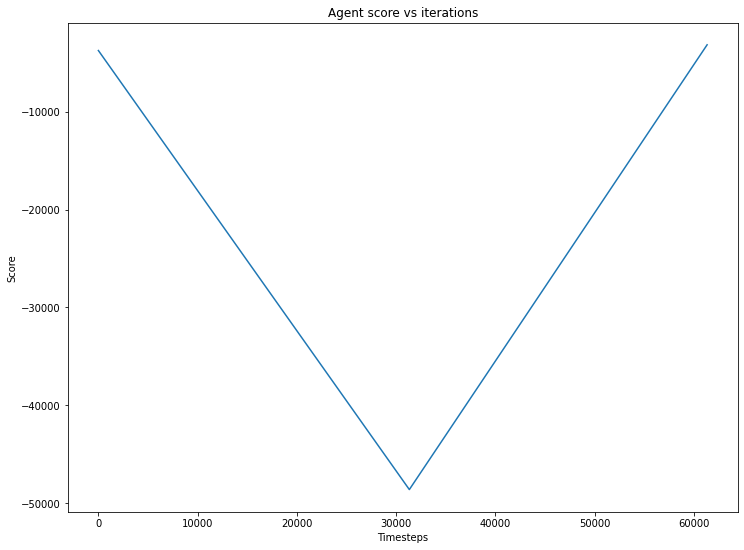

In [0]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot( evaluation_timesteps, evaluations )
ax.set_ylabel('Score')
ax.set_xlabel('Timesteps')
ax.set_title('Agent score vs iterations');

# Inference

In [0]:
policy_inference = TD3(state_dim, action_dim, max_action, device)
policy_inference.load(file_name, './pytorch_models/')

env_inference = CityMap(citymap, roadmask, car_image_resized, render_pov = 'map')
env_inference = wrappers.Monitor(env_inference, monitor_dir, force = True, video_callable=lambda episode_id: True)

avg_reward_inference = evaluate_policy(policy_inference, env_inference, eval_episodes=3)
print("Iter 1 avg reward: ", avg_reward_inference)

# Wrapup recording
env_inference.close()
env_inference.stats_recorder.save_complete()
env_inference.stats_recorder.done = True

env_inference = CityMap(citymap, roadmask, car_image_resized, render_pov = 'car')
env_inference = wrappers.Monitor(env_inference, monitor_car_pov_dir, force = True, video_callable=lambda episode_id: True)

avg_reward_inference = evaluate_policy(policy_inference, env_inference, eval_episodes=3)
print("Iter 2 avg reward: ", avg_reward_inference)

# Wrapup recording
env_inference.close()
env_inference.stats_recorder.save_complete()
env_inference.stats_recorder.done = True

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
Average Reward over the Evaluation Step: -20577.060258
---------------------------------------
Iter 1 avg reward:  -20577.060258386362


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
Average Reward over the Evaluation Step: -19788.749159
---------------------------------------
Iter 2 avg reward:  -19788.7491594367
